# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
from umap import UMAP

In [2]:
!pip install jsonlines

In [3]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict
import itertools
import operator
from tqdm import tqdm

## I. N-Gram Language Modeling

#### Utilities

In [4]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [6]:
datasets, vocab = load_wikitext()

Vocab size: 33175


### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:

# delta = 0.0005
# for n in [2, 3, 4]:
#     lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm.estimate(datasets['train'])

#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    pass

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

## II. Neural Language Modeling with a Recurrent Neural Network

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, RandomSampler, SequentialSampler,DataLoader
import matplotlib.pyplot as plt

### Utilities

In [8]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>') # validation token is not seen in the training dataset
                                # <unk> is in the original training dataset. 
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [9]:
train_dict=Dictionary(datasets) # excluding validation dataset #109
#all_dict=Dictionary(datasets, include_valid = True)

# example
rand_int = np.random.randint(1, len(datasets['valid']))
print(' '.join(datasets['valid'][rand_int]))
encoded = train_dict.encode_token_seq(datasets['valid'][rand_int])
print(f'\n encoded - {encoded}')
decoded = train_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

# checking
print('length of train_dict is ', len(train_dict)) # that's because <unk> is already in the dataset 
print('unique words in training dataset is ', len(vocab))

100%|██████████| 78274/78274 [02:36<00:00, 501.68it/s]

In 2000 , <unk> played a significant role in the Knights ' rushing and return game .

 encoded - [632, 5843, 10, 3, 726, 20, 1744, 22, 33, 6, 18924, 273, 13964, 30, 158, 26, 39]

 decoded - ['In', '2000', ',', '<unk>', 'played', 'a', 'significant', 'role', 'in', 'the', 'Knights', "'", 'rushing', 'and', 'return', 'game', '.']
length of train_dict is  33178
unique words in training dataset is  33175


In [10]:
# given the dictionary from above, now write a function that tokenize the all datasets into id's
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

# Given a tokenzied dataset with ngram defined, slice the input sequences into n-grams 
# [0,1,2,3,4,5], 2 -> [0,1], [1,2], [2,3], [3,4], [4,5]
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=2):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

# # Now we create a dataset
class NgramDataset(Dataset):
    def __init__(self, sliced_dataset_split):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.tensor(i, dtype=torch.long) for i in sliced_dataset_split]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)

def batchify(list_minibatch):
    inp_list = [i[:-1] for i in list_minibatch]
    tar_list = [i[-1] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=0) # list of tensors and create a new tensor a u-dimension specified by dim
    tar_tensor = torch.stack(tar_list, dim=0)
    # cat: take a list of tensors and use existing dimension to concatent. Cannot create a new u-dimension speicfied. 

    return inp_tensor, tar_tensor

In [11]:
#  returns dictionary of three items with 'train', 'valid' and 'test' with lists of token ids 
tokenized_ngram = tokenize_dataset(datasets, train_dict, ngram_order=2)

# returns dictionary of three items, each item is a list of sliced n-grams
sliced_ngram = slice_sequences_given_order(tokenized_ngram, ngram_order=2)

# check that the sentence is encoded with (n-1)<bos> and can be decoded back to tokens 
decoded_with_spec = train_dict.decode_idx_seq(tokenized_ngram['train'][3010])
print(f'\n decoded with spec - {decoded_with_spec}')

ngram_datasets = {}
ngram_loaders = {}
for split, dataset_sliced in sliced_ngram.items():
    if split == 'train':
        shuffle_ = True
    else:
        shuffle_ = False
    dataset_ = NgramDataset(dataset_sliced)
    ngram_datasets[split] = dataset_
    ngram_loaders[split] = DataLoader(dataset_, batch_size=2048, shuffle=shuffle_, collate_fn=batchify)

100%|██████████| 9708/9708 [00:00<00:00, 96878.45it/s]



 decoded with spec - ['<bos>', 'The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.', '<eos>']


In [12]:
print('The length of original training dataset is: ', len(datasets['train']))
print('The length of tokenzied training dataset is: ', len(tokenized_ngram['train']))
print('Slided_ngram for training dataset now has length of ', len(sliced_ngram['train']))

The length of original training dataset is:  78274
The length of tokenzied training dataset is:  78274
Slided_ngram for training dataset now has length of  2003028


In [13]:
print(tokenized_ngram['valid'][10])
print(train_dict.decode_idx_seq(tokenized_ngram['valid'][10]))

[0, 504, 1506, 7106, 741, 459, 20, 140, 98, 432, 19366, 10, 150, 15605, 13, 260, 3748, 955, 1826, 1384, 1145, 98, 1722, 4303, 39, 1]
['<bos>', 'This', 'may', 'occur', 'several', 'times', 'a', 'year', 'for', 'young', 'lobsters', ',', 'but', 'decreases', 'to', 'once', 'every', '1', '–', '2', 'years', 'for', 'larger', 'animals', '.', '<eos>']


In [14]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])
    
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors]) # t.size(-1) changes the type from torch.Size to int.
    padded_list = []
    
    for t in list_of_tensors:  # dim = 0: cat on row, dim = 1: add on column 
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor



In [15]:
tensor_dataset = {}

# split: train, valid, test
for split, listoflists in tokenized_ngram.items():
    tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
tensor_dataset['train'][24]

(tensor([[  0, 282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39]]),
 tensor([[282,  13, 283, 181, 194, 195, 284,  13,  20, 285, 286,  39,   1]]))

In [16]:

loaders = {}
batch_size = 32
for split, dataset in tensor_dataset.items():
    loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle = True, collate_fn=pad_collate_fn)
    
    # why is shuffle always TRUE in this loader? even for valid and test

### Baseline Model: RNN

In [17]:
from torch.nn import RNNBase, RNN
from torch.nn import Embedding
from torch.nn import Linear, functional
import torch.optim as optim

In [18]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        # before nn.RNN is hidden
        # Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
        # RNN natrually takes multi sentence inputs and outputs hidden_size 
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        # project of outputs 
        # rnn_outputs: tuple with second element being last hidden state. 
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
# check
# define lookup, rnn, and projection
# lookup table: stores embeddings of a fixed dictionary and size.
lookup = nn.Embedding(num_embeddings=options['num_embeddings'], 
                      embedding_dim=options['embedding_dim'], 
                      padding_idx=options['padding_idx'])

# before nn.RNN is hidden
# Now: you do lookup table, and returns the tensors of sequence. No need of concat, becuase RNN naturally takes care of this
# RNN natrually takes multi sentence inputs and outputs hidden_size 
rnn = nn.RNN(options['input_size'], options['hidden_size'], 
             options['num_layers'], dropout=options['rnn_dropout'], 
             batch_first=True)
# input_size == embedding_dimension
projection = nn.Linear(options['hidden_size'], options['num_embeddings'])

Embedding(33178, 64, padding_idx=2)

In [0]:
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt') # change the model name
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    rnn_dropout = 0.1
    input_size = lookup.weight.size(1) # embedding_dim
    vocab_size = lookup.weight.size(0) # num_embeddings
    
    model = RNNLanguageModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

# change the type from generator to list 
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)



In [0]:
lookup # embedding_size, embedding_dim

Embedding(33178, 300, padding_idx=2)

In [0]:
rnn # embedding_dim, hidden_size

RNN(300, 300, num_layers=2, batch_first=True, dropout=0.1)

In [0]:
projection 
# in_features – size of each input sample = hidden_size
# out_features – size of each output sample = number of possible next token
# bias – If set to False, the layer will not learn an additive bias. Default: True

Linear(in_features=300, out_features=33178, bias=True)

In [0]:
# check model
model

RNNLanguageModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (rnn): RNN(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [0]:
# check the following two chunks out

In [0]:

plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Step 0 avg train loss = 10.4347
Step 100 avg train loss = 7.7255
Step 200 avg train loss = 6.9448
Step 300 avg train loss = 6.7479
Step 400 avg train loss = 6.6020
Step 500 avg train loss = 6.5238
Step 600 avg train loss = 6.4444
Step 700 avg train loss = 6.3687
Step 800 avg train loss = 6.3088
Step 900 avg train loss = 6.2642
Step 1000 avg train loss = 6.2030
Step 1100 avg train loss = 6.1762
Step 1200 avg train loss = 6.1313
Step 1300 avg train loss = 6.1102
Step 1400 avg train loss = 6.0654
Step 1500 avg train loss = 6.0286
Step 1600 avg train loss = 6.0137
Step 1700 avg train loss = 5.9976
Step 1800 avg train loss = 5.9683
Step 1900 avg train loss = 5.9564
Step 2000 avg train loss = 5.9412
Step 2100 avg train loss = 5.9246


KeyboardInterrupt: ignored

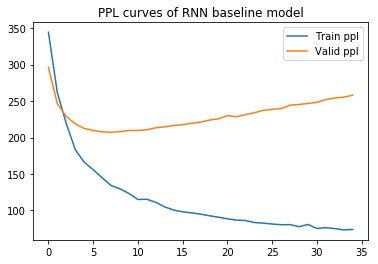

In [0]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of RNN baseline model')
plt.show()

### II.1 LSTM and Hyper-Parameters

In [20]:
from torch.nn import LSTM
# input_size, hidden_size, num_layers. 
# Optional: bias = False, dropout = 0 (probability of dropout)
# bidirectional = False. 
rnn = nn.LSTM(10, 20, 2)

# input: tensor containing feature of the input sequence 
# shape: seq_len, batch, input_size
input = torch.randn(5,3,10)

# h0: tensor contain hidden state for t = seq_len
# shape: num_layers * num*directions, batch, hidden_size
h0 = torch.randn(2,3,20)

# c0: tensor contain cell state for t = seq_length
# shape: num_layers * num_directions, batch, hidden_size 
c0 = torch.randn(2,3,20)

# output: shape (seq_len, batch, num_direction * hidden size)
output, (hn,cn) = rnn(input, (h0,c0))

In [25]:
# # example embedding layer
# lookup = Embedding(num_embeddings=len(train_dict), embedding_dim=64, padding_idx=train_dict.get_id('<pad>'))
# lookup.weight.size()
# # train_dict = vocab size + 3

torch.Size([33178, 64])

In [21]:
# From the baseline, we will stop the epoch around 20 
class LSTMModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], 
                            dropout=options['lstm_dropout'], batch_first=True, bias = options['bias'],
                           bidirectional = options['bid'])
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [0]:

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = LSTMModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128 # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
#     input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    
    model = LSTMModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [28]:
model

LSTMModel(
  (lookup): Embedding(33178, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)

In [0]:
# The following cell geives the performance of the baseline LSTM
# TAKE A LONG TIME TO RUN. 

In [0]:
#model = LSTMModel(options).to(current_device)
plot_cache = []
min_val_loss = 20 
for epoch_number in range(20):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
                        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
        
print('Saving best model...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './baseline_LSTM.pt')



Step 0 avg train loss = 7.0863
Step 100 avg train loss = 7.0200
Step 200 avg train loss = 6.9266
Step 300 avg train loss = 6.8133
Step 400 avg train loss = 6.7200
Step 500 avg train loss = 6.6318
Step 600 avg train loss = 6.5733
Step 700 avg train loss = 6.5168
Step 800 avg train loss = 6.4810
Step 900 avg train loss = 6.4369
Step 1000 avg train loss = 6.3943
Step 1100 avg train loss = 6.3615
Step 1200 avg train loss = 6.3266
Step 1300 avg train loss = 6.2870
Step 1400 avg train loss = 6.2620
Step 1500 avg train loss = 6.2168
Step 1600 avg train loss = 6.2051
Step 1700 avg train loss = 6.1710
Step 1800 avg train loss = 6.1293
Step 1900 avg train loss = 6.1156
Step 2000 avg train loss = 6.0862
Step 2100 avg train loss = 6.0944
Step 2200 avg train loss = 6.0612
Step 2300 avg train loss = 6.0266
Step 2400 avg train loss = 6.0032
Validation loss after 0 epoch = 5.8233
Step 0 avg train loss = 5.8466
Step 100 avg train loss = 5.9111
Step 200 avg train loss = 5.8860
Step 300 avg train loss = 

KeyboardInterrupt: ignored

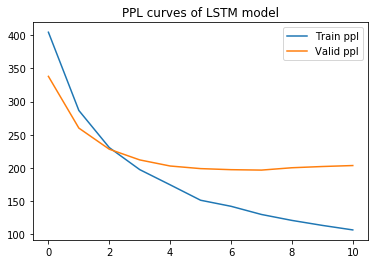

In [0]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of LSTM model')
plt.show()

In [0]:
perp = [2**(i[1]/np.log(2)) for i in plot_cache] 
print('The minimum validation loss occurred at {} and it is {}'.format(perp.index(min(perp)),min(perp)))

The minimum validation loss occurred at 7 and it is 196.54008318910067


In [0]:
# train the model with hyperparamters chosen: embed_dim: 300, hidden_zise = 300

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = LSTMModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 300
    hidden_size = 300 # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
#     input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)
    
    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    
    model = LSTMModel(options).to(current_device)

# same as previous nn based 
criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [30]:
# verify the model 
model

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [0]:
#model = LSTMModel(options).to(current_device)
# train the model with hyperparamters chosen: embed_dim: 300, hidden_zise = 300

plot_cache = []
min_val_loss = 20 
epoch_num = 20
for epoch_number in range(epoch_num):
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
            print("update the best to:")
            print(best_model)
            print("current validation loss is:")
            print(min_val_loss)
                        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
        
print('Saving best model...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './best_300_300_LSTM.pt')



Step 0 avg train loss = 7.0963
Step 100 avg train loss = 7.1643
Step 200 avg train loss = 6.9912
Step 300 avg train loss = 6.8097
Step 400 avg train loss = 6.6316
Step 500 avg train loss = 6.5043
Step 600 avg train loss = 6.4055
Step 700 avg train loss = 6.3217
Step 800 avg train loss = 6.2781
Step 900 avg train loss = 6.1911
Step 1000 avg train loss = 6.1272
Step 1100 avg train loss = 6.0845
Step 1200 avg train loss = 6.0255
Step 1300 avg train loss = 6.0025
Step 1400 avg train loss = 5.9498
Step 1500 avg train loss = 5.9080
Step 1600 avg train loss = 5.8947
Step 1700 avg train loss = 5.8399
Step 1800 avg train loss = 5.7976
Step 1900 avg train loss = 5.8105
Step 2000 avg train loss = 5.7670
Step 2100 avg train loss = 5.7527
Step 2200 avg train loss = 5.7363
Step 2300 avg train loss = 5.6854
Step 2400 avg train loss = 5.6774
Validation loss after 0 epoch = 5.5204
update the best to:
LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batc

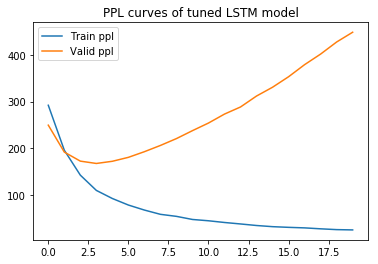

In [0]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves of tuned LSTM model')
plt.show()

In [0]:
perp = [2**(i[1]/np.log(2)) for i in plot_cache] 
print('The minimum validation loss occurred at {} and it is {}'.format(perp.index(min(perp)),min(perp)))

The minimum validation loss occurred at 3 and it is 168.0075867791675


#### Results (LSTM vs. Baseline)

In [0]:
# first hyperparameter tuning: embedding dimension: 100 - 500


if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
# single grid search for the hyperparameter tuning
param_grid_emb = {"embedding_size": [100,200,300,400,500]}      

# list of parameters=========== 
epoch_num = 20
hidden_size = 128 # the second hyperparameter to be tuned. 
learning_rate=0.001
# Loop over embedding size:
for embedding_size in param_grid_emb["embedding_size"]:
  
    embedding_size = embedding_size
    hidden_size = hidden_size # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
    # input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)

    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    model = LSTMModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=learning_rate)

    print(model)

    plot_cache = []
    min_val_loss = 20   # why is it 20??

    for epoch_number in range(epoch_num):

    # do train 
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())

            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []

    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model

    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

# save the best model in this single grid search:         
print('Saving best model with best embedding dimension...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model.state_dict()
        }, './emb_tune_best_LSTM.pt')



  

LSTMModel(
  (lookup): Embedding(33178, 100, padding_idx=2)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33178, bias=True)
)
Step 0 avg train loss = 10.4213
Step 100 avg train loss = 7.8746
Step 200 avg train loss = 7.1487
Step 300 avg train loss = 6.9989
Step 400 avg train loss = 6.8819
Step 500 avg train loss = 6.7695
Step 600 avg train loss = 6.6904
Step 700 avg train loss = 6.6061
Step 800 avg train loss = 6.5169
Step 900 avg train loss = 6.4813
Step 1000 avg train loss = 6.4483
Step 1100 avg train loss = 6.3791
Step 1200 avg train loss = 6.3451
Step 1300 avg train loss = 6.3354
Step 1400 avg train loss = 6.2372
Step 1500 avg train loss = 6.2236
Step 1600 avg train loss = 6.1985
Step 1700 avg train loss = 6.1570
Step 1800 avg train loss = 6.1361
Step 1900 avg train loss = 6.1115
Step 2000 avg train loss = 6.0735
Step 2100 avg train loss = 6.0716
Step 2200 avg train loss = 6.0352
Step 2300 avg train loss =

In [0]:
# second hyperparameter tuning: hidden size: 100- 500 
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

# single grid search for the hyperparameter tuning
param_grid_hid_size = {"hidden_size": [300,400,500]}    # tried 100, 200 before.

# list of parameters=========== 
epoch_num = 20
embedding_size = 300 # find the best embedding size 5.2010 after 5 epoch
learning_rate=0.001
overall_min_val_loss = 20
# Loop over embedding size:
for hidden_size in param_grid_hid_size["hidden_size"]:
  
    embedding_size = embedding_size
    hidden_size = hidden_size # output of dimension 
    num_layers = 2
    lstm_dropout = 0.1
    # input_size = lookup.weight.size(1)
    vocab_size = len(train_dict)

    options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }

    model = LSTMModel(options).to(current_device)

    criterion = nn.CrossEntropyLoss(ignore_index=train_dict.get_id('<pad>'))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=learning_rate)

    print(model)

    plot_cache = []
    min_val_loss = 20   

    for epoch_number in range(epoch_num):

    # do train 
    avg_loss=0
    if not load_pretrained:
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())

            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []

    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        best = avg_val_loss < min_val_loss
        if best:
            min_val_loss = avg_val_loss
            best_model = model
            print("update best model with this parameter to :")
            print(best_model)

    plot_cache.append((avg_loss, avg_val_loss))


    if load_pretrained:
        break

    if (min_val_loss < overall_min_val_loss):
    best_model_overall = best_model
    overall_min_val_loss = min_val_loss
    print("update overall best model to :")
    print(best_model_overall)
    
# save the best model in this single grid search:         
print('Saving best model with best hidden size...')
torch.save({
'options': options,
'loss_cache': plot_cache,
'model_dict': best_model_overall.state_dict()
        }, './hid_tune_best_LSTM.pt')

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)
Step 0 avg train loss = 10.4099
Step 100 avg train loss = 7.6503
Step 200 avg train loss = 7.1205
Step 300 avg train loss = 6.9481
Step 400 avg train loss = 6.7299
Step 500 avg train loss = 6.5959
Step 600 avg train loss = 6.4814
Step 700 avg train loss = 6.3755
Step 800 avg train loss = 6.3012
Step 900 avg train loss = 6.2247
Step 1000 avg train loss = 6.1656
Step 1100 avg train loss = 6.1052
Step 1200 avg train loss = 6.0663
Step 1300 avg train loss = 6.0285
Step 1400 avg train loss = 5.9922
Step 1500 avg train loss = 5.9431
Step 1600 avg train loss = 5.9030
Step 1700 avg train loss = 5.8825
Step 1800 avg train loss = 5.8530
Step 1900 avg train loss = 5.8168
Step 2000 avg train loss = 5.7784
Step 2100 avg train loss = 5.7565
Step 2200 avg train loss = 5.7259
Step 2300 avg train loss =

FileNotFoundError: ignored

In [88]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Performance Variation Based on Hyperparameter Values

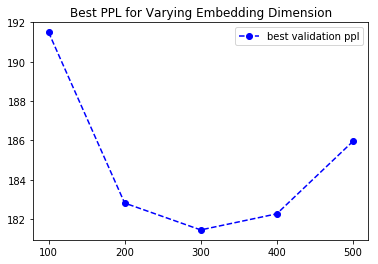

In [86]:
# embedding_dim: 100-200-300-400-500 with default hidden_size: 128
# [5.2549,5.2085,5.2010,5.2055,5.2255]
# 6 - 5 - 5 - 5 - 4 epoch]

with open('tune_val_loss.pkl', 'rb') as f:
    tune_val_loss = pickle.load(f)

plot_emb = tune_val_loss[0]
perp_emb = [2**(i/np.log(2)) for i in plot_emb] 

emb = np.array([100,200,300,400,500])
plt.plot(hid, perp_emb, color='b', linestyle='dashed', marker='o', 
         label='best validation ppl' )

plt.legend()
plt.xticks(np.arange(100, 600, step=100))
plt.title('Best PPL for Varying Embedding Dimension')
plt.show()

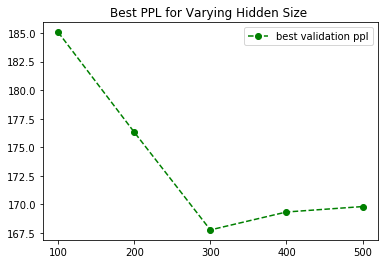

In [87]:
# hidden_size: 100-200-300-400-500 with best embedding_dim: 300
# 5.2207 - 5.1723 - 5.1226 - 5.1319 - 5.1347
# 7 - 4 - 3 - 3 - 3

plot_hid = tune_val_loss[1]
perp_hid = [2**(i/np.log(2)) for i in plot_hid] 

hid = np.array([100,200,300,400,500])
plt.plot(hid, perp_hid, color='g', linestyle='dashed', marker='o', label='best validation ppl' )

plt.legend()
plt.xticks(np.arange(100, 600, step=100))
plt.title('Best PPL for Varying Hidden Size ')
plt.show()

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [22]:
# best parameter: 
options = {'bias': True,
  'bid': False,
  'embedding_dim': 300,
  'hidden_size': 300,
  'input_size': 300,
  'lstm_dropout': 0.1,
  'num_embeddings': 33178,
  'num_layers': 2,
  'padding_idx': 2}
    
model = LSTMModel(options)
model.load_state_dict(torch.load('best_emb_dim_300_hidden_size_300_LSTM.pt',map_location=lambda storage, loc: storage)['model_dict'])
model.eval()

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [23]:
import sys
!{sys.executable} -m pip  install adjustText

In [38]:
%pylab inline 
import umap
import matplotlib.pyplot as plt
from adjustText import adjust_text

colors = ['red','gold','limegreen','cornflowerblue','mediumpurple',
          'darkred','lightcoral',
          'darkgoldenrod','wheat',
         'darkgreen','lightgreen',
          'midnightblue','lightsteelblue',
         'indigo','thistle']

def umap_plot(weight_matrix, word_ids):
    # darker color indicates best, 
    # light color indicates worst
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy()) 
    # transfer tensor back to cpu
    plt.figure(figsize=(20,20))
    texts = []
    for i, iid in enumerate(word_ids): 
        token = train_dict.get_token(iid)
        to_plot = reduced[iid, :]
        plt.scatter(to_plot[0], to_plot[1], color = colors[i],marker = '*', s = 350)
        texts.append(plt.annotate(token, (to_plot[0], to_plot[1])))
        for j, word_list in enumerate([word_ids[iid]['best'],word_ids[iid]['worst']]):
            to_plot = reduced[word_list, :]
            plt.scatter(to_plot[:, 0], to_plot[:, 1], color = colors[5+i+j])
            # now annotate:
            for k,w in enumerate(word_list):
                current_point = to_plot[k]
                texts.append(plt.annotate(train_dict.get_token(w), (current_point[0], current_point[1])))
    adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>",
                                                    color='r', alpha=0.5))
    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


#### II.2.1 Word Similarity

In [26]:
def cos_similarity(weight_matrix, words):
#make sure at least appear in the text once 
    for word in words:
        if word not in vocab:
            raise NotImplementedError("selected token must appeared in the corpus once, please replace {}".format(word))

    # define my cosine similarity. each input is 1 x emb_dim. Therefore evaluate along x'axis returns a scalar 
    cos = nn.CosineSimilarity(dim = 0, eps = 1e-6)

    token_list = defaultdict(lambda: defaultdict(float))
    id_list = defaultdict(lambda: defaultdict(float))

    for w in words:
        wid = train_dict.get_id(w)
        temp_list = list()
        for i in range(len(weight_matrix)):
            if i == wid:
                continue
            else: 
                dis = cos(weight_matrix[wid], weight_matrix[i])
                temp_list.append(tuple((i, dis.item())))
        temp_list = sorted(temp_list, key = lambda x: x[-1])
        id_list[wid]['worst'] = [x[0] for x in temp_list[:10]]
        id_list[wid]['best'] = [x[0] for x in temp_list[-10:]]
        token_list[w]['worst'] = [tuple((train_dict.get_token(x[0]) , x[1])) for x in temp_list[:10]]
        token_list[w]['best'] = [tuple((train_dict.get_token(x[0]) , x[1] )) for x in temp_list[-10:]]
    return id_list, token_list

#### II.2.2 Embedding Layer

In [28]:
weight_matrix_lkup = model.lookup.weight
input_words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
lkup_id_list, lkup_token_list = cos_similarity(weight_matrix_lkup, input_words)

In [29]:
lkup_token_list['smart']['best']

[('adequately', 0.19367575645446777),
 ('electroplating', 0.1939428597688675),
 ('1623', 0.19624313712120056),
 ('Bolton', 0.19649575650691986),
 ('Walking', 0.20014889538288116),
 ('Ackroyd', 0.20353351533412933),
 ('seasonal', 0.20835746824741364),
 ('uptempo', 0.22692306339740753),
 ('Kurt', 0.2292158007621765),
 ('13', 0.23212550580501556)]

In [30]:
lkup_token_list['smart']['worst']

[('Stephanie', -0.25110581517219543),
 ('Precinct', -0.2189103066921234),
 ('forget', -0.21829074621200562),
 ('sparkling', -0.218269482254982),
 ('Hibari.', -0.20343728363513947),
 ('pareiasaur', -0.2009078711271286),
 ('permanence', -0.1899358034133911),
 ('odes', -0.18928715586662292),
 ('Statistics', -0.18898172676563263),
 ('artist', -0.18862245976924896)]

/Users/lexili24/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


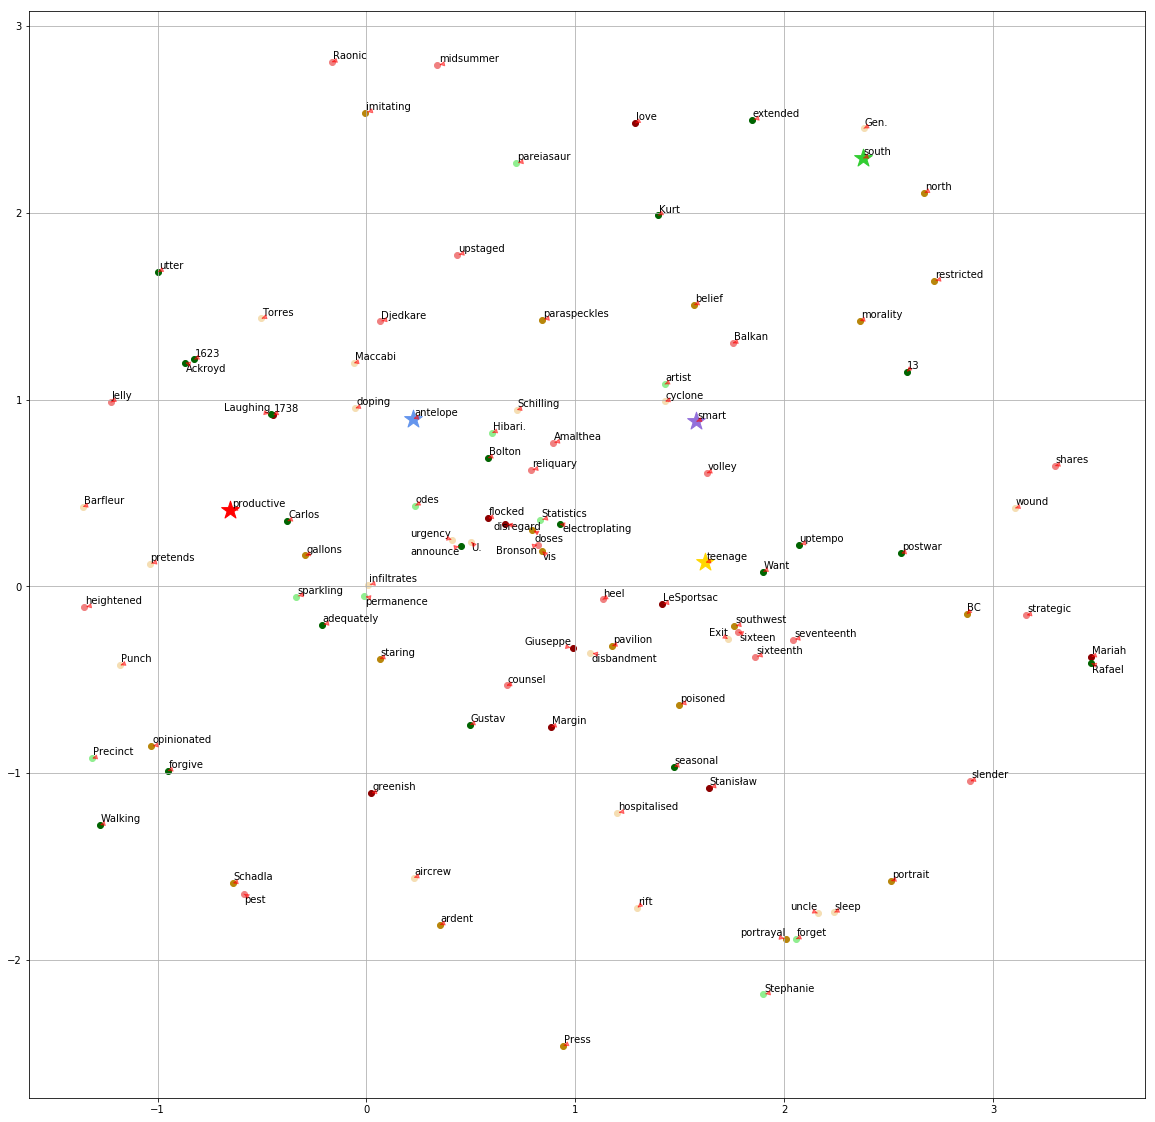

In [39]:
umap_plot(weight_matrix_lkup, lkup_id_list)

#### II.2.3 Projection Layer

In [34]:
weight_matrix_proj = model.projection.weight
input_words = ['productive', 'teenage','south','antelope','smart']
# some verbs, and nouns
proj_id_list, proj_token_list = cos_similarity(weight_matrix_proj, input_words)

In [35]:
proj_token_list['productive']['best']

[('lifesize', 0.6370277404785156),
 ('defensible', 0.637245237827301),
 ('sprawling', 0.640779972076416),
 ('willed', 0.6415868401527405),
 ('clockwise', 0.6472915410995483),
 ('dose', 0.6574928760528564),
 ('cutaway', 0.6576105952262878),
 ('precaution', 0.6598490476608276),
 ('minded', 0.6629545092582703),
 ('soundstage', 0.6735890507698059)]

In [36]:
proj_token_list['productive']['worst']

[('Kansas', 0.23528103530406952),
 ('Oregon', 0.23573540151119232),
 ('Cloud', 0.24489308893680573),
 ('Bright', 0.24528267979621887),
 ('Aden', 0.24741169810295105),
 ('Vietnamese', 0.24973073601722717),
 ('Tokyo', 0.2505605220794678),
 ('Cruise', 0.2509114742279053),
 ('Rhodesia', 0.25127601623535156),
 ('Heritage', 0.2524130344390869)]

/Users/lexili24/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


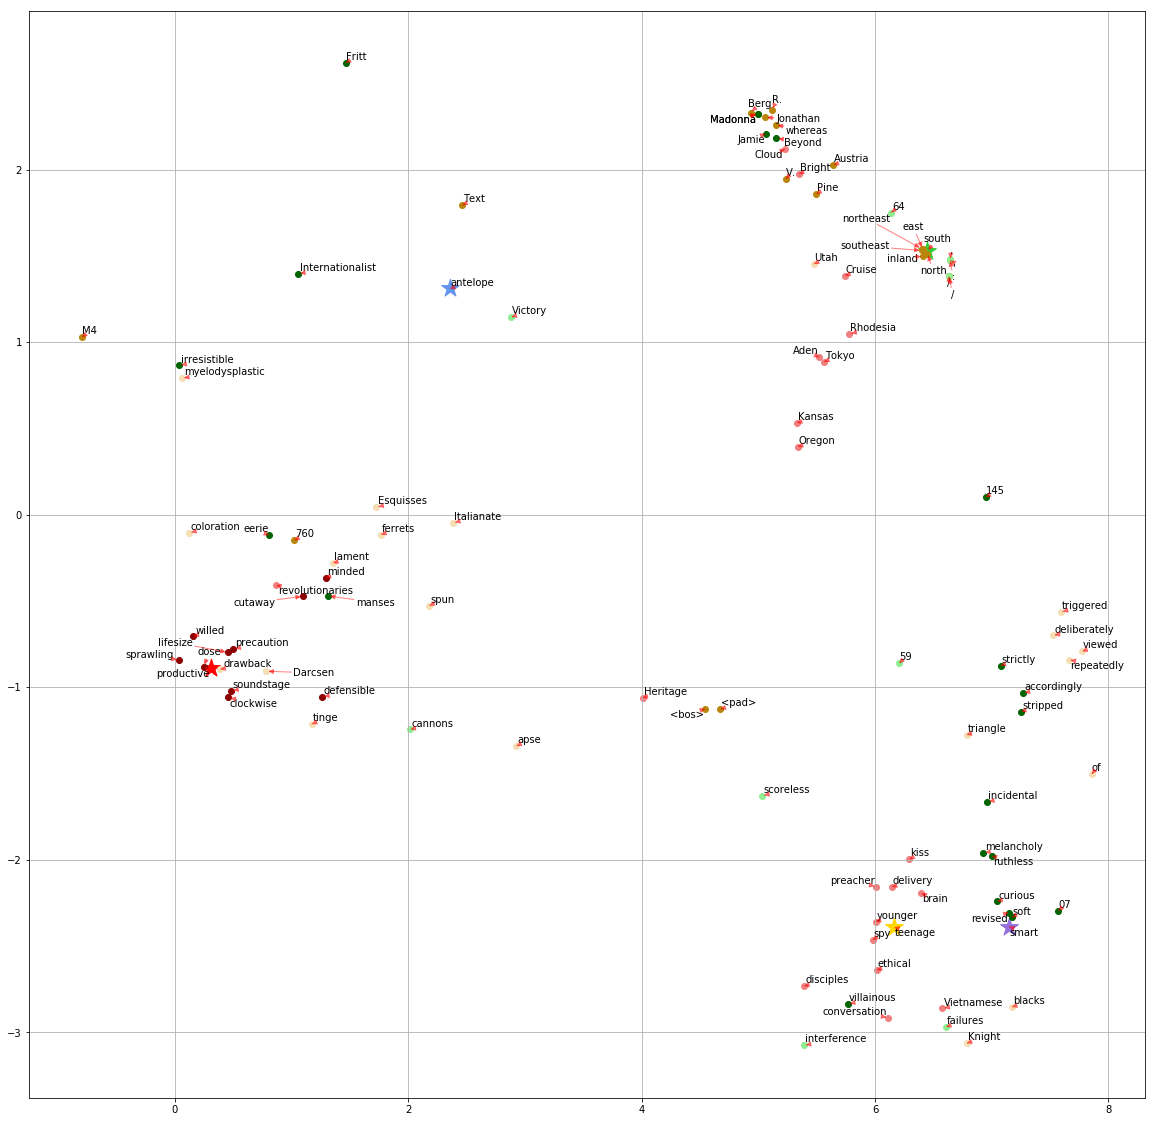

In [40]:
umap_plot(weight_matrix_proj, proj_id_list)

### Observation:
From the graph we can see that the embedding and projection layer visualizations are significantly different. The embedding layer cannot really differentiate each word, therefore no cluster is really formed as all words are scattered in the graph. However in the projection layer, words are clustered into groups. Taken for an example, we see a group of 'Utah, Bright, Tokyo, Kansas, Aden, and Oregon', which to me are ideally as the model seems to correctly seperates objectives with location names. However, not all best, worst of words selected are interpretable. For a full list of words produced from a list of words we chose from, reference below: 

In [ ]:
print('Five words we chose are: ', input_words/)
print('The words we selected from embedding layers are', whole_words_lkup)
print('The words we selected from project layers are', whole_words_proj)

### II.3 Scoring

In [0]:
def get_logprob(seq, model):
    """ Input: a sentence (string) 
      Output: the averaged log probability of the sentence.
    """
    inp = [train_dict.get_id('<bos>')] + train_dict.encode_token_seq(seq.split(' '))
    target = inp[1:] + [train_dict.get_id('<eos>')]

    with torch.no_grad():
        model.eval()
        logits = model(torch.tensor([inp], dtype=torch.long))

    num = len(inp)-1 # minus the <bos>
    logp = 0
    for i in range(num):
    # get the correct next word from the tarfet list.
    next_word = target[i]   
    # get teh distribution of the next possible word. 
    prob_dist = torch.softmax(logits[0,i], dim= -1) 
    # not sure whether to add this sentence.. 
    # prob_dist = prob_distr.current_device()

    # get the prob for the correct next word. 
    logp += np.log(prob_dist[next_word]).item()

    return logp/num


In [0]:
# load the best model:
embedding_size = 300
hidden_size = 300

options = {
        'num_embeddings': len(train_dict),
        'embedding_dim': embedding_size,
        'padding_idx': train_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        'bias': True,
        'bid': False 
    }
model = LSTMModel(options)
model.load_state_dict(torch.load(F'/content/drive/My Drive/NLP/best_emb_dim_300_hidden_size_300_LSTM.pt')['model_dict'])
model.eval()

LSTMModel(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# test the function: 
get_logprob("I love cats and dogs.", model)

-9.40573251247406

#### II.3.2 Highest and Lowest scoring sequences

In [0]:
# get a list of all sentences in the validation datasets.
wiki_valid = [' '.join(a for a in aaa) for aaa in datasets['valid']]

# get the score for each sentence
logp_valid = [get_logprob(seq, model) for seq in wiki_valid]

# sort the logp
sorted_logp_valid = [i for i in sorted(enumerate(logp_valid), key=lambda x:x[1])]

# get ten sentences with the lowest score.
low_idx = [l[0] for l in sorted_logp_valid[:10]]
low_score = [l[1] for l in sorted_logp_valid[:10]]
low_seq = [wiki_valid[i] for i in low_idx]

# get ten sentences with the highest score.
high_idx = [l[0] for l in sorted_logp_valid[-10:]]
high_score = [l[1] for l in sorted_logp_valid[-10:]]
high_seq = [wiki_valid[i] for i in high_idx]


In [0]:
# print the higest scored sentences
print("These are the sentences withe the highest score:")
[print(f'sentence: {i}') for i in high_seq]
print("\n")
# pritn the lowest scored sentences
print("These are the sentences withe the lowest score:")
[print(f'sentence: {i}') for i in low_seq]


These are the sentences withe the highest score:
sentence: = = Post @-@ war period = =
sentence: " Daydream Interlude ( Fantasy Sweet Dub Mix ) "
sentence: The series depicts the everyday lives of office employees in the Scranton , Pennsylvania branch of the fictional Dunder Mifflin Paper Company .
sentence: The VHS was a commercial success , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units .
sentence: A Critical Guide to The X @-@ Files , Millennium & The Lone Gunmen , rated " ...
sentence: It originally aired on the Fox network in the United States on March 4 , 2012 .
sentence: = = Post @-@ war career = =
sentence: The Boat Race is a side @-@ by @-@ side rowing competition between the University of Oxford ( sometimes referred to as the " Dark Blues " ) and the University of Cambridge ( sometimes referred to as the " Light Blues " ) .
sentence: This means that it was seen by 4 @.@ 0 % of all 18- to 49 @-@

[None, None, None, None, None, None, None, None, None, None]

#### II.3.3 Modified sequences

In [0]:
# choose a long ont to midofy 

mod_low = " The VHS was a commercial failure , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units . "
mod_high = " The VHS was a commercial tea , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units . "
print(f'Original: \n {high_seq[3]} \nScore: \n {high_score[3]}')
print(f'Replace success with failure: \n {mod_low} \nScore: \n {get_logprob(mod_low,model)}')
print(f'Replace success with tea: \n {mod_high} \nScore: \n {get_logprob(mod_high,model)}')


Original: 
 The VHS was a commercial success , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units . 
Score: 
 -1.6729712699229518
Replace success with failure: 
  The VHS was a commercial failure , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units .  
Score: 
 -2.5508986361164716
Replace success with tea: 
  The VHS was a commercial tea , being certified platinum by the Recording Industry Association of America ( RIAA ) , denoting shipments of over 100 @,@ 000 units .  
Score: 
 -3.7741181976816733


### II.4 Sampling

In [41]:
class LSTMModelHidden(nn.Module):
    """
    This model Integrate from the previous LSTM model and has a hidden layer as input
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], 
                            dropout=options['lstm_dropout'], batch_first=True, bias = options['bias'],
                           bidirectional = options['bid'])
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence, hidden):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs,hidden = self.lstm(embeddings,hidden)
        # project of outputs 
        # rnn_outputs: tupple with second element being last hidden state. 
        logits = self.projection(lstm_outputs)
        
        return logits, hidden

In [42]:
# Load the best model
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

options = {'bias': True,
  'bid': False,
  'embedding_dim': 300,
  'hidden_size': 300,
  'input_size': 300,
  'lstm_dropout': 0.1,
  'num_embeddings': 33178,
  'num_layers': 2,
  'padding_idx': 2}
    
model = LSTMModelHidden(options)
model.load_state_dict(torch.load('best_emb_dim_300_hidden_size_300_LSTM.pt',map_location=lambda storage, loc: storage)['model_dict'])
model.eval()

LSTMModelHidden(
  (lookup): Embedding(33178, 300, padding_idx=2)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=300, out_features=33178, bias=True)
)

In [43]:
#from torch.distributions.multinomial import Multinomial

def generate_sentence():
    # We always begin with <bos> and end at <eos>
    begin_id = torch.tensor(train_dict.get_id('<bos>'))
    end_id = torch.tensor(train_dict.get_id('<eos>'))

    # this is the initialized hidden layer with all zeros
    h = torch.zeros(options['num_layers'],1,options['hidden_size'])
    c = torch.zeros(options['num_layers'],1,options['hidden_size'])

    next_word = begin_id
    tokens = list()
    tokens.append(next_word)

    while next_word != end_id:  # make sure both are type tensor
        # Feeding in the hidden states at each state
        output, (h,c) = model.forward(next_word.view(1,-1), (h,c)) 
        
        # initialize a softmax function
        m = nn.Softmax(dim=-1)
        prob = m(output.view(-1))

        # use multinomial to predict the next token
        next_word = torch.multinomial(prob,1)
        
        tokens.append(next_word.item())

    sentence = train_dict.decode_idx_seq(tokens)
    return ' '.join(sentence)

In [44]:
sentences = list()
for _ in range(1000):
    st = generate_sentence()
    sentences.append(st)

In [45]:
# an example of generated sentence 
item = np.random.randint(1000)
sentences[item]

'<bos> Researchers , like perhaps the oldest deity of the English language as an example of social life , and is similarly of human but secondary . <eos>'

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [46]:
# find the first 1000 sentences from validation samples
valid_sentences = []
samples = np.arange(len(datasets['valid']))
np.random.shuffle(samples)
for i in range(1000):
    valid_sentences.append('<bos> '+' '.join(datasets['valid'][samples[i]])+' <eos>')

In [47]:
# unique set of validation sample
unique_valid = len(set(' '.join(valid_sentences)))
print('Number of unique words in the validation sequences is ', unique_valid)
unique_generate = len(set(' '.join(sentences)))
print('Number of unique words from sampling sequences is ', unique_generate)

Number of unique words in the validation sequences is  100
Number of unique words from sampling sequences is  112


In [48]:
print('Avg length of validation sequences is ', sum([len(i) for i in valid_sentences])/len(valid_sentences))
print('Avg length of sampling sequences is', sum([len(i) for i in sentences])/len(sentences))

Avg length of validation sequences is  130.501
Avg length of sampling sequences is 139.785


From the comparision we can see that for both unique words and average length, validation and sampling sequences are almost similar, although average validation sequence length and number of unique words are lower than sampling sequences overall. 

#### II.4.4 Example Samples

In [49]:
samples = np.arange(1000)
np.random.shuffle(samples)
print(sentences[samples[0]])
print(sentences[samples[1]])
print(sentences[samples[2]])

<bos> The Turin canon credits des education and public products in China ; the former initiated a small bottle bridge event linked to the church including the Byrds . <eos>
<bos> unk> on a star that was a weaker surface and so the urn will make <unk> about discovering the foul jumps in the deep atmosphere ; this was later mixed and had originated from the Tech <unk> which made " <unk> escaping back " . <eos>
<bos> After little changes , none more closely fused without Hurricane condoms may continue as <unk> , resulting in shrubby environments . <eos>


From those samples above, although the property of unique word and sentence length are consistent with human-generated sentences, but I can still tell that there are model generated since they hardly stay on topic, although they seem to be grammatically correct as the position of the word make sense. 